In [3]:
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import numpy as np

#### Parametri e condizioni iniziali

In [14]:
###########################################################################
# Dati sperimetali
molecules_per_uM = 500 # molecole/uM : circa 500 molecole per avere una concentrazione molare di 1 uM


###########################################################################
#  Parameters
n = 3 # hill parameter

alpha_1 = 0.2 # uM/ min
alpha_2 = alpha_1 

beta_1 = 4 # uM/ min
beta_2 = beta_1 

K1 = 1 # uM
K2 = K1

d1_base = 1 # 1/min. Si chiama base perchè è il valore per istanti iniziali (fra 0 e 60 min). Dopodichè aumenta (vedi dopo)
d2 = d1_base

gamma = 1 # 1/min

epsilon = 1

s = 1.7  # adimensional



###########################################################################
# Initial conditions
u_0 = 2125 # numero di molecole!
v_0 = 125 # numero di molecole!

def from_molecules_to_uM(molecules):
    return molecules / molecules_per_uM

def from_uM_to_molecules(uM):
    return uM * molecules_per_uM

# intial conditions in uM
u_0 = from_molecules_to_uM(u_0)
v_0 = from_molecules_to_uM(v_0)
print(f"Initial conditions: u_0 = {u_0:.2f} uM, v_0 = {v_0:.2f} uM")


###########################################################################
# MMC induction window
t_start = 60 # min
t_end = 960 # min


Initial conditions: u_0 = 4.25 uM, v_0 = 0.25 uM


**Riguardo al parametro d1:**

- d₁ è il tasso di degradazione della proteina λCI.

- Normalmente vale d₁ = 1 min⁻¹, ma quando la cellula subisce danno al DNA (indotto dalla mitomicina C, MMC) la proteina RecA si lega a λCI e ne aumenta la degradazione.

    - Prima e dopo l’induzione (t < 60 min o t > 960 min): d1 = d1_base = 1; 
    - Durante l’induzione (60 ≤ t ≤ 960 min): d1= d1_base + gamma*s / (1+s)
- Nel modello del paper la prima ora (t < 60 min) serve per far stabilizzare il sistema nello stato iniziale ad alto λCI. Invece il trattamento con MMC dura 15h, per questo dopo 960 min d1 torna al livello base

#### Modello deterministico


In [15]:
def make_toggle_switch_ode(alpha_1, beta_1, alpha_2, beta_2,
                           K1, K2, d1_base, n, d2, gamma, epsilon, t_start=60, t_end=960):
    """
    Factory for build genetic switch deterministic  model
    """

    def d1(t, s):
        if t < t_start or t > t_end:
            return d1_base
        else:
            return d1_base + gamma * s / (1 + s)
    
    def hill_function(x, K):
        """
        Function to be used in the ODEs to model the Hill function.
        Args:
            x : number of molecules of one of the two species (u or v)
            K : ? a parameter that sets the threshold for the Hill function
        """
        return K**n / (K**n + x**n)

    def genetic_switch_ode(t, y, s):
        u, v = y # current values. u= λCI, v = LacR
        du = epsilon * (alpha_1 + beta_1 * hill_function(v, K1) - d1(t, s) * u)
        dv = epsilon * (alpha_2 + beta_2 * hill_function(u, K2) - d2 * v)
        return [du, dv]

    return genetic_switch_ode



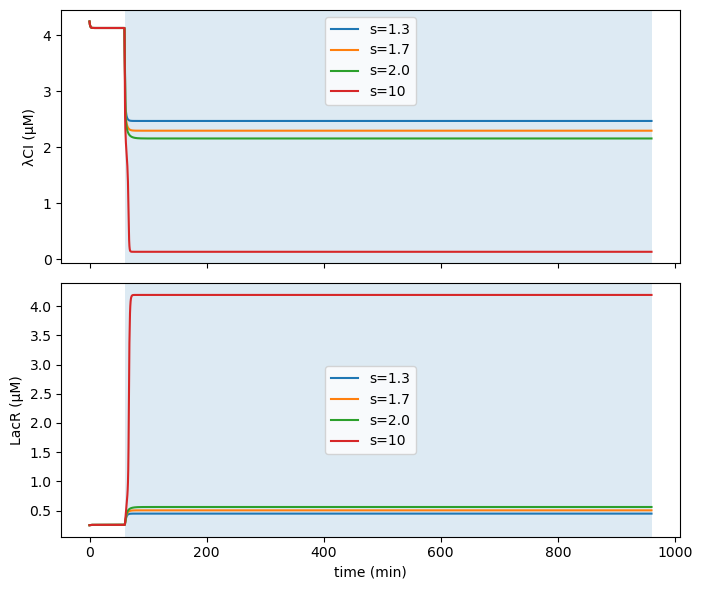

In [24]:
ode_system = make_toggle_switch_ode(alpha_1, beta_1, alpha_2, beta_2, K1, K2, d1_base, n, d2, gamma, epsilon)

t_sim = [0, t_end] # simulation time (min)
y0 = [u_0, v_0]

def run_sim(s, t_end=1200):
    sol = solve_ivp(lambda t, y: ode_system(t, y, s),
                    t_sim, y0, max_step=0.5)
    return sol

# Try a few s values around the reported threshold range
s_values = [1.3, 1.7, 2.0, 10]
sims = [run_sim(s) for s in s_values]

# Plot time courses
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True)
for s, sol in zip(s_values, sims):
    t, u, v = sol.t, sol.y[0], sol.y[1]
    axes[0].plot(t, u, label=f"s={s}")
    axes[1].plot(t, v, label=f"s={s}")

axes[0].axvspan(t_start, t_end, alpha=0.15)
axes[1].axvspan(t_start, t_end, alpha=0.15)
axes[0].set_ylabel("λCI (μM)")
axes[1].set_ylabel("LacR (μM)")
axes[1].set_xlabel("time (min)")
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()


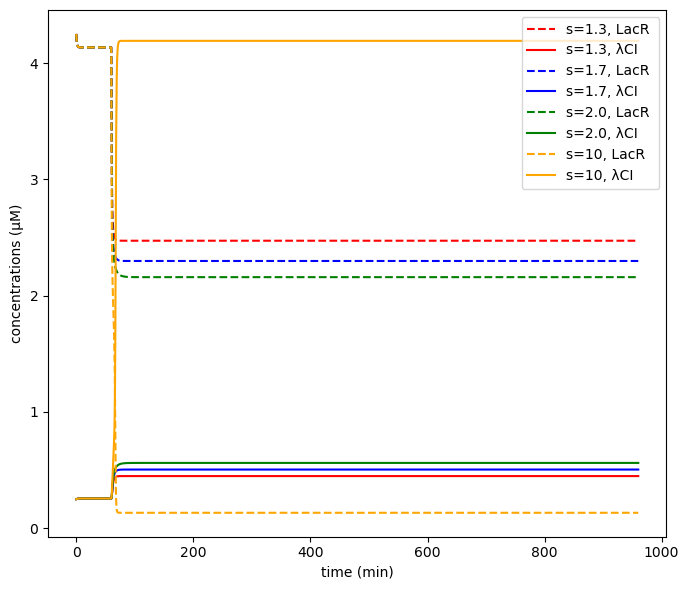

In [28]:
# Plot time courses
fig = plt.figure(figsize=(7,6))
color_idx, color_list = 0, ["red", "blue", "green", "orange"]
for s, sol in zip(s_values, sims):
    t, u, v = sol.t, sol.y[0], sol.y[1]
    plt.plot(t, u, color=color_list[color_idx], linestyle='dashed', label=f"s={s}, LacR ")
    plt.plot(t, v, color=color_list[color_idx], label=f"s={s}, λCI ")
    color_idx+=1

plt.ylabel("concentrations (μM)")
plt.xlabel("time (min)")
plt.legend()
plt.tight_layout()
plt.show()

The deterministic model switches only for very big value of $s$!